# Analysis of Elevation Profiles of Hiking Trails

## Introduction 
This project focuses on the analysis of elevation profiles of hiking trails. The data sources used are hiking trails from [OpenStreetMap (OSM)](https://www.openstreetmap.org) and elevation data from the [DMR 5G](https://ags.cuzk.cz/arcgis/rest/services/3D/dmr5g/ImageServer) obtained from the [Czech Office for Surveying, Mapping and Cadastre (ČÚZK)](https://cuzk.cz). The project primarily focuses on hiking trails marked by the [Czech Tourist Club (KČT)](https://www.kct.cz).


## Import of libraries
#### Import standard libraries
[os](https://docs.python.org/3/library/os.html)  
[warnings](https://docs.python.org/3/library/warnings.html)  

#### Import libraries for data and geospatial data processing
[requests](https://docs.python-requests.org/en/latest/)  
[geopandas](https://geopandas.org/)  
[rasterio](https://rasterio.readthedocs.io/en/latest/)  
[shapely](https://shapely.readthedocs.io/en/stable/)  

#### Import libraries for visualization
[matplotlib](https://matplotlib.org/)  

#### Import libraries for working with OSM data
[osmapi](https://osmapi.tilmannr.de/)


In [1]:
# Import standard libraries
import os
import warnings

# Import libraries for data and geospatial data processing
import requests
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, LineString

# Import libraries for visualization
import matplotlib.pyplot as plt

# Import libraries for working with OSM data
import osmapi

The hiking trail relation is downloaded using [OsmApi](https://osmapi.tilmannr.de/). A complete overview of hiking trail numbers in the Czech Republic is available [here](https://osm.paws.cz/hiking.php).

In [2]:
# Function to download a relation by its ID
def download_relation(relation_id):
    try:
        with osmapi.OsmApi() as api:
            return api.RelationGet(relation_id)
    except osmapi.errors.ElementDeletedApiError:
        print(f"Relation with ID {relation_id} has been deleted.")
        return None

Example Usage

In [3]:
# Example ID
relation_id = 334313
relation = download_relation(relation_id)
print(relation)

{'id': 334313, 'visible': True, 'version': 48, 'changeset': 159671790, 'timestamp': datetime.datetime(2024, 11, 27, 18, 14, 37), 'user': 'sannorra', 'uid': 1424365, 'tag': {'complete': 'yes', 'educational': 'yes', 'kct_yellow': 'major', 'name': 'Sigmondova okružní naučná stezka', 'network': 'lwn', 'note': 'Značena žlutým pásovým značením', 'official_name': 'Sigmondova okružní NS', 'operator': 'cz:KČT', 'osmc:symbol': 'yellow:white:yellow_bar', 'ref': '6711', 'route': 'hiking', 'type': 'route'}, 'member': [{'type': 'node', 'ref': 364493953, 'role': 'guidepost'}, {'type': 'node', 'ref': 676243685, 'role': 'guidepost'}, {'type': 'node', 'ref': 676475796, 'role': 'guidepost'}, {'type': 'node', 'ref': 655359905, 'role': 'guidepost'}, {'type': 'node', 'ref': 806808290, 'role': 'guidepost'}, {'type': 'node', 'ref': 2205940692, 'role': 'board'}, {'type': 'node', 'ref': 2205940676, 'role': 'board'}, {'type': 'node', 'ref': 676243685, 'role': 'guidepost'}, {'type': 'node', 'ref': 7099707271, 'ro

In [4]:
# Function to extract descriptive route information from a relation
def extract_route_info(relation):
    tags = relation.get('tag', {})
    route_info = {
        'id': relation['id'],
        'name': tags.get('name', 'Name not provided'),
        'official_name': tags.get('official_name', 'Official name not provided'),
        'route_type': tags.get('route', 'Unknown route type'),
        'operator': tags.get('operator', 'Operator not provided'),
        'symbol': tags.get('osmc:symbol', 'Symbol not provided'),
        'ref': tags.get('ref', 'Reference not provided'),
        'complete': tags.get('complete', 'Not specified'),
        'educational': tags.get('educational', 'Not specified'),
        'network': tags.get('network', 'Unknown network'),
        'kct_yellow': tags.get('kct_yellow', 'Not specified'),
        'note': tags.get('note', 'No note provided'),
    }
    return route_info

In [5]:
# Extract descriptive path information
route_info = extract_route_info(relation)

# Print descriptive path information
print("Descriptive information about the path:")
for key, value in route_info.items():
    print(f"{key}: {value}")

Descriptive information about the path:
id: 334313
name: Sigmondova okružní naučná stezka
official_name: Sigmondova okružní NS
route_type: hiking
operator: cz:KČT
symbol: yellow:white:yellow_bar
ref: 6711
complete: yes
educational: yes
network: lwn
kct_yellow: major
note: Značena žlutým pásovým značením


Function to save relation to geodataframe

In [6]:
def relation_to_geodataframe(relation):
    """
    Converts a relation dictionary into a GeoDataFrame.
    Assumes 'members' contain 'ways' with references to geometry data, and ignores nodes.
    """
    members = relation.get('member', [])
    data = []
    
    for member in members:
        member_type = member.get('type')
        ref = member.get('ref')
        role = member.get('role', '')
        
        if member_type == 'way':
            # Fetch geometry for "way" using the API
            with osmapi.OsmApi() as api:
                way = api.WayGet(ref)
                nodes = way['nd']
                coords = [(api.NodeGet(node_id)['lon'], api.NodeGet(node_id)['lat']) for node_id in nodes]
                geometry = LineString(coords)
                data.append({
                    'type': member_type,
                    'ref': ref,
                    'role': role,
                    'geometry': geometry
                })

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry='geometry')
    return gdf


Example of usage

In [7]:
# Example usage
gdf = relation_to_geodataframe(relation)
display(gdf.head())

,type,ref,role,geometry
0,way,841270075,,"LINESTRING (13.38333 49.78979, 13.38328 49.789..."
1,way,1111089511,,"LINESTRING (13.38315 49.78947, 13.38278 49.789..."
2,way,32399132,,"LINESTRING (13.38224 49.78926, 13.38162 49.789..."
3,way,1111089513,,"LINESTRING (13.38120 49.78914, 13.38107 49.78914)"
4,way,1111089512,,"LINESTRING (13.38107 49.78914, 13.38048 49.78912)"


In [8]:
# Function to determine the trail color from the "osmc:symbol" tag
def get_trail_color(symbol):
    # Examples of mapping the symbol to a color (you can add more symbols as needed)
    if 'yellow' in symbol:
        return 'yellow'
    elif 'red' in symbol:
        return 'red'
    elif 'green' in symbol:
        return 'green'
    elif 'blue' in symbol:
        return 'blue'
    else:
        return 'gray'  # Default color if no match


In [9]:
# Function to display a GeoDataFrame with route name and color
def plot_route_map(gdf, route_info):
    # Get the route name from route_info
    route_name = route_info.get('name', 'No name provided')
    
    # Get the trail color based on the symbol from route_info
    trail_symbol = route_info.get('symbol', 'yellow:white:yellow_bar')
    trail_color = get_trail_color(trail_symbol)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the GeoDataFrame with the color
    gdf.plot(ax=ax, color=trail_color, alpha=0.7, linewidth=2, label=route_name)
    
    # Add title and legend
    plt.title(f"Tourist Path: {route_name}", fontsize=16)
    plt.legend()
    plt.show()


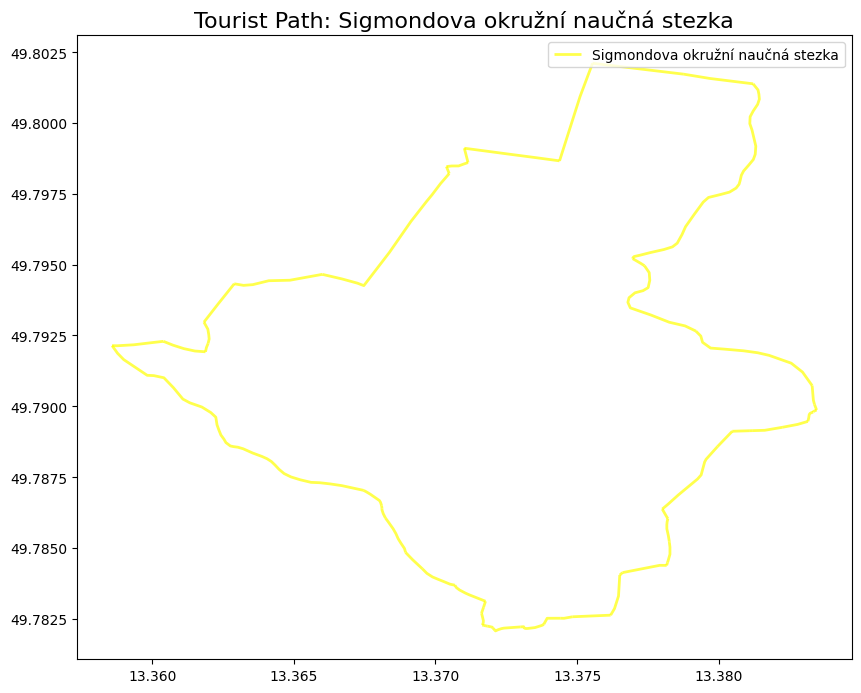

In [10]:
plot_route_map(gdf, route_info)

In [11]:
import folium

bounds = gdf.total_bounds

center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]

m = folium.Map(location=center, zoom_start=10)

trail_symbol = route_info.get('symbol', 'yellow:white:yellow_bar')

trail_color = get_trail_color(trail_symbol)

gdf.explore(m=m, tiles="carto positron", color=trail_color)

display(m)



NameError: name 'folium' is not defined